In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import numpy as np
import scipy.stats as st
from scipy.stats.stats import pearsonr
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import BicScore, K2Score, BDeuScore
from pgmpy.estimators import HillClimbSearch, PC, MmhcEstimator
from pgmpy.estimators import TreeSearch
from pgmpy.models import BayesianNetwork
import networkx as nx
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import warnings

<ipython-input-1-c3e4ebe4466f>:10: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
warnings.filterwarnings(action='ignore')

In [ ]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pd.options.display.float_format ='{:,.3f}'.format

In [4]:
data = pd.read_csv('hour.csv', delimiter=',', encoding='utf-8')

# Step 1. Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 – target variables, the rest - predictors).

In [5]:
columns = ['mnth', 'hr', 'weekday', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
target_columns = ['casual', 'registered', 'cnt']

data_subsample = data[columns]
data_subsample = data_subsample[1500:2250]
data_subsample.head()

,mnth,hr,weekday,temp,atemp,hum,windspeed,casual,registered,cnt
1500,3,21,1,0.280,0.273,0.380,0.224,1,53,54
1501,3,22,1,0.260,0.258,0.480,0.164,1,34,35
1502,3,23,1,0.280,0.318,0.480,0.000,0,22,22
1503,3,0,2,0.260,0.288,0.480,0.090,1,9,10
1504,3,1,2,0.240,0.242,0.520,0.134,0,4,4


In [6]:
bikes = data_subsample.dropna()

In [7]:
len(bikes)

750

# Step 2. Using univariate parametric distributions that were fitted in Lab#2 make sampling of chosen target variables. Use for this 2 different sampling methods.

In [21]:
bikes_random = bikes.sample(frac=0.5)

In [22]:
def inverse_transform_sampling(data):
  params = st.gamma.fit(data)
  data_rnd = np.random.uniform(size=len(data))
  gen = st.gamma(*params)
  return gen.ppf(data_rnd)

In [23]:
ts_1 = inverse_transform_sampling(bikes['casual'])
ts_2 = inverse_transform_sampling(bikes['registered'])
ts_3 = inverse_transform_sampling(bikes['cnt'])
bikes_inv_ts = pd.DataFrame({'casual': ts_1, 'registered': ts_2, 'cnt': ts_3})

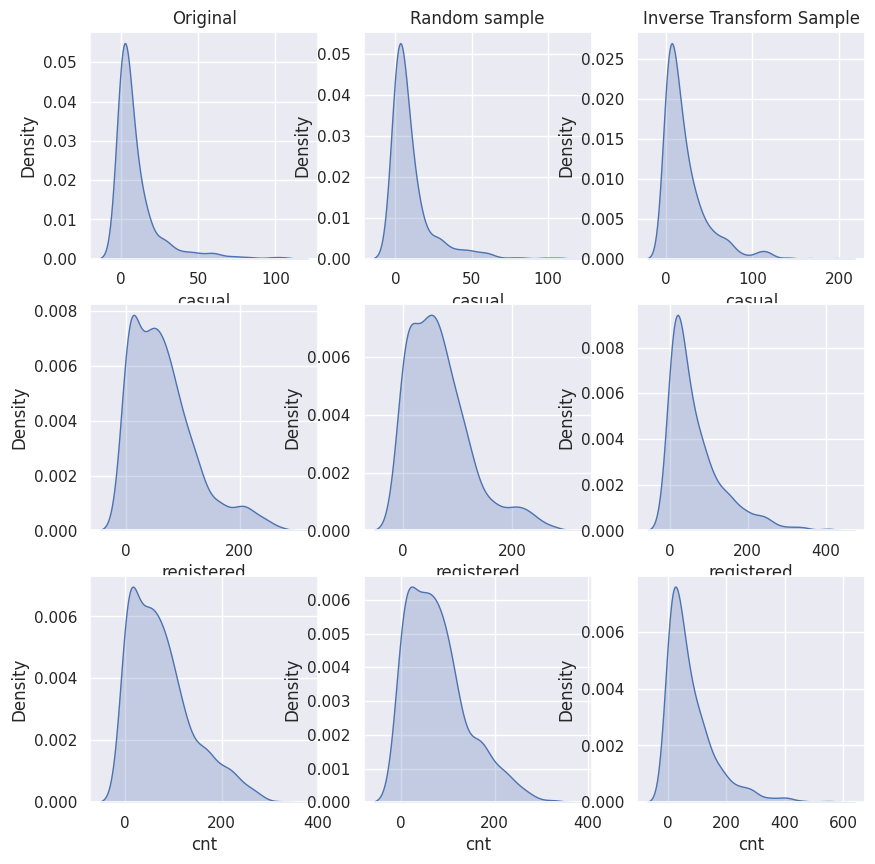

In [24]:
warnings.filterwarnings(action='ignore')
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
ax[0, 0].set_title('Original')
ax[0, 1].set_title('Random sample')
ax[0, 2].set_title('Inverse Transform Sample')
sns.kdeplot(bikes['casual'], ax=ax[0, 0], shade=True)
sns.kdeplot(bikes_random['casual'], ax=ax[0, 1], shade=True)
sns.kdeplot(bikes_inv_ts['casual'], ax=ax[0, 2], shade=True)
sns.kdeplot(bikes['registered'], ax=ax[1, 0], shade=True)
sns.kdeplot(bikes_random['registered'], ax=ax[1, 1], shade=True)
sns.kdeplot(bikes_inv_ts['registered'], ax=ax[1, 2], shade=True)
sns.kdeplot(bikes['cnt'], ax=ax[2, 0], shade=True)
sns.kdeplot(bikes_random['cnt'], ax=ax[2, 1], shade=True)
sns.kdeplot(bikes_inv_ts['cnt'], ax=ax[2, 2], shade=True)
plt.show()

In [25]:
print(bikes[target_columns].mean())
print(bikes_random[target_columns].mean())
print(bikes_inv_ts[target_columns].mean())

casual       10.383
registered   65.049
cnt          75.432
dtype: float64
casual       10.205
registered   66.909
cnt          77.115
dtype: float64
casual       22.281
registered   66.248
cnt          80.568
dtype: float64


# Step 3. Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients.

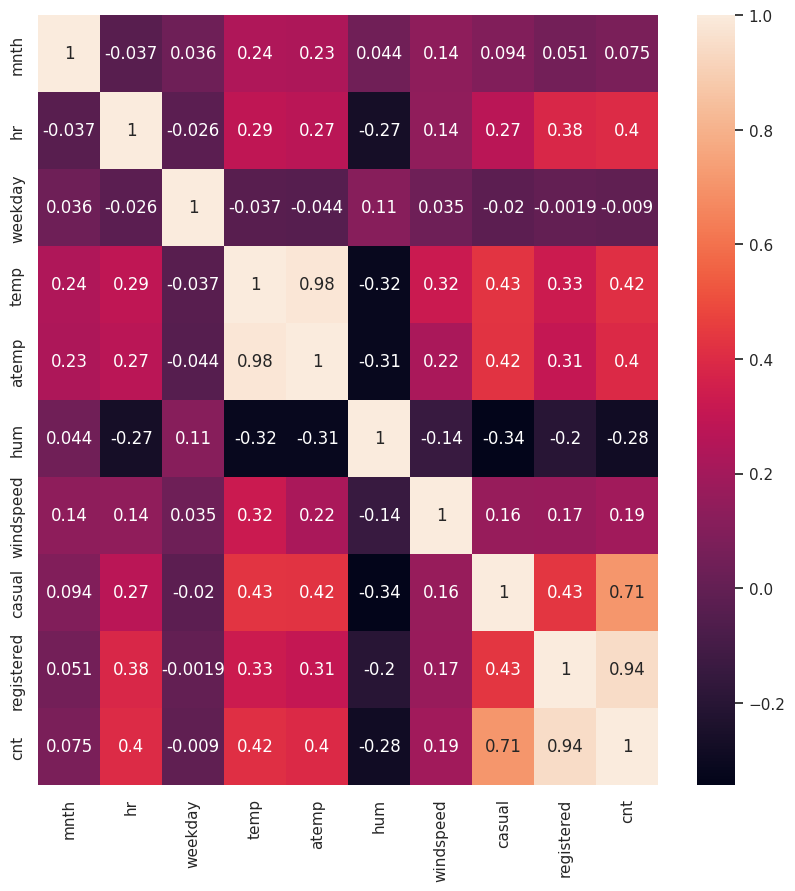

In [91]:
corrMatrix = bikes.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

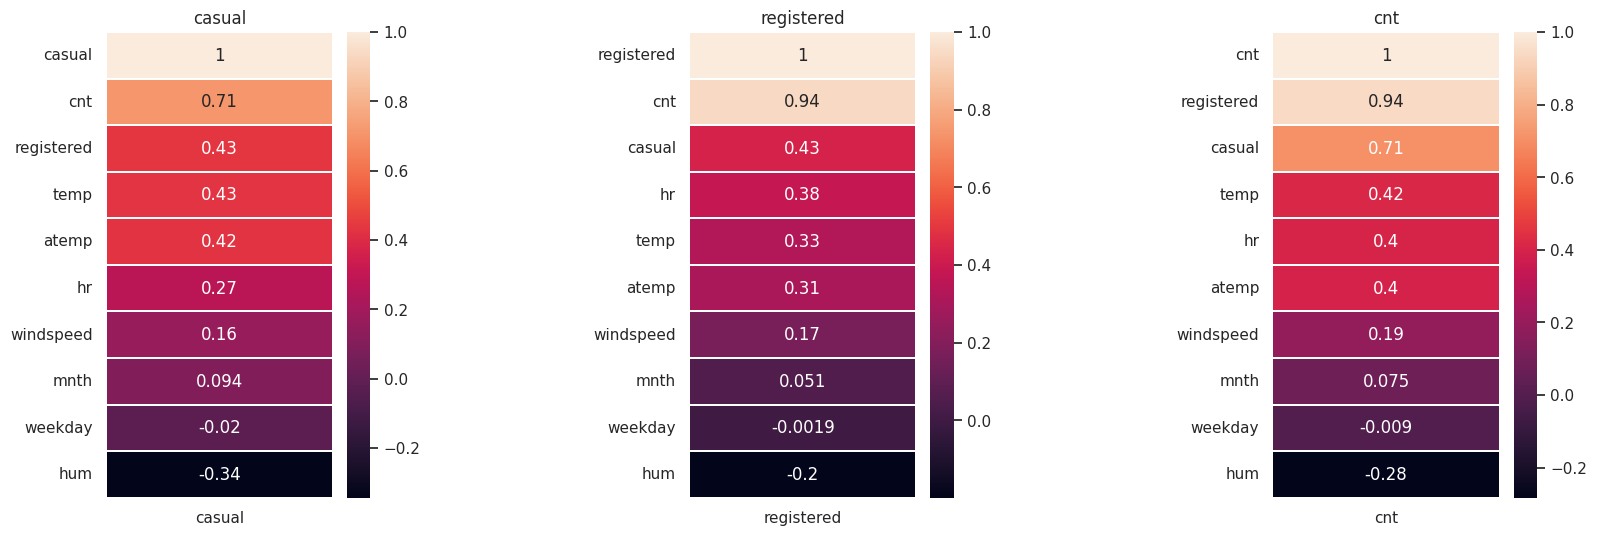

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.set_theme()
fig.tight_layout(pad=15.0)

ax[0].set_title('casual')
ax[1].set_title('registered')
ax[2].set_title('cnt')

sns.heatmap(
    bikes.corr()[['casual']].sort_values(by='casual', ascending=False),
    annot=True,
    linewidths=0.25,
    ax=ax[0]
)
sns.heatmap(
    bikes.corr()[['registered']].sort_values(by='registered', ascending=False),
    annot=True,
    linewidths=0.25,
    ax=ax[1]
)
sns.heatmap(
    bikes.corr()[['cnt']].sort_values(by='cnt', ascending=False),
    annot=True,
    linewidths=0.25,
    ax=ax[2]
)


plt.show()

# Step 4. Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

In [7]:
columns

['mnth',
 'hr',
 'weekday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt']

In [8]:
pairs = [
    ('temp', 'casual'),
    ('atemp', 'casual'),
    ('cnt', 'casual'),
    ('atemp', 'registered'),
    ('temp', 'registered'),
    ('hr', 'registered'),
    ('atemp', 'cnt'),
    ('temp', 'cnt'),
    ('mnth', 'cnt')
]

model = BayesianModel(pairs)

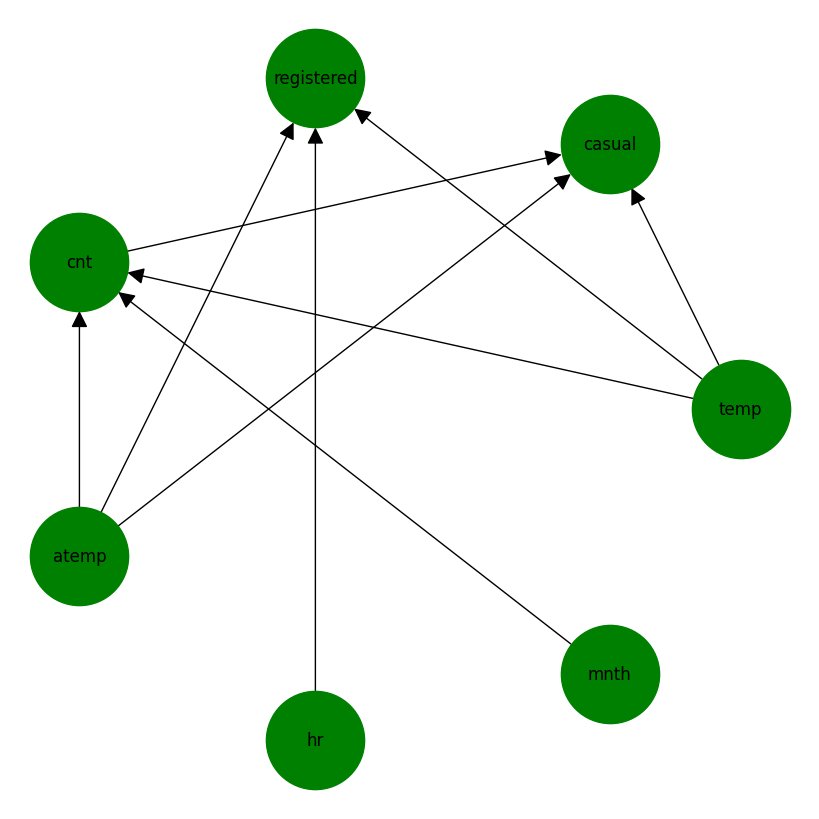

In [9]:
G = nx.DiGraph()
G.add_edges_from(model.edges())
pos = nx.layout.circular_layout(G)
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='green', node_size=5000, arrowsize=25)

In [10]:
model.fit(bikes)

# Step 5. Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning.

In [13]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import BicScore, K2Score
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import TreeSearch
from sklearn.preprocessing import KBinsDiscretizer

In [11]:
[['mnth', 'hr', 'weekday', 'temp', 'atemp', 'windspeed', 'casual', 'registered', 'cnt']]

[['mnth',
  'hr',
  'weekday',
  'temp',
  'atemp',
  'windspeed',
  'casual',
  'registered',
  'cnt']]

In [14]:
discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="kmeans")
bikes_discrete = discretizer.fit_transform(bikes.values)
bikes_discrete = pd.DataFrame(bikes, columns=columns)

In [15]:
hc = HillClimbSearch(data=bikes_discrete[['mnth', 'hr', 'weekday', 'temp', 'atemp', 'windspeed', 'casual', 'registered', 'cnt']])
model2 = hc.estimate(scoring_method=K2Score(bikes_discrete[['mnth', 'hr', 'weekday', 'temp', 'atemp', 'windspeed', 'casual', 'registered', 'cnt']]), show_progress=False)

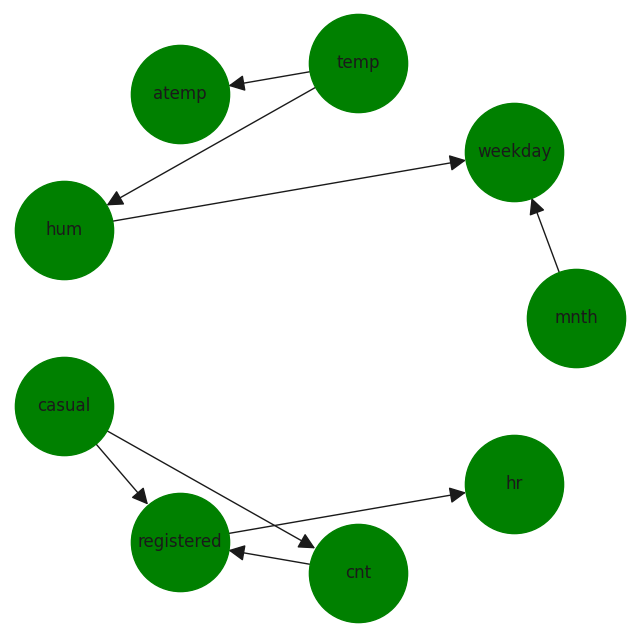

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))
G = nx.DiGraph()
G.add_edges_from(model2.edges())
positions = nx.layout.circular_layout(G)
nx.draw(G, positions, with_labels=True, node_color='green', node_size=5000, arrowsize=25)

In [16]:
ts = TreeSearch(bikes_discrete)
model3 = ts.estimate()

Building tree:   0%|          | 0/36.0 [00:00<?, ?it/s]

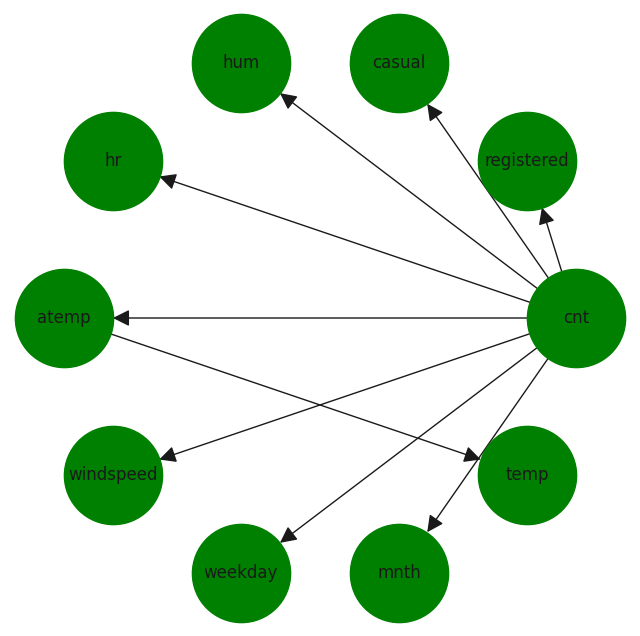

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
G = nx.DiGraph()
G.add_edges_from(model3.edges())
positions = nx.layout.circular_layout(G)
nx.draw(G, positions, with_labels=True, node_color='green', node_size=5000, arrowsize=25)

In [26]:
print("Metrics:")
print("My bayesian network")
print(f'K2: {K2Score(bikes).score(model):.2f}')
print("PC")
print(f'K2: {K2Score(bikes_discrete).score(model2):.2f}')
print("Tree Search")
print(f'K2: {K2Score(bikes_discrete).score(model3):.2f}')

Metrics:
My bayesian network
K2: -20852.42
PC
K2: -20779.00
Tree Search
K2: -24973.43


# Step 6. Analyze a quality of sampled target variables from the point of view of problem statement (e.g. prediction, gap filling, synthetic generation).

In [17]:
def sampling (model, data, n):
    temp = BayesianModel(model.edges())
    temp.fit(data)
    sampler = BayesianModelSampling(temp)
    sample = sampler.forward_sample(size=n)
    return sample

In [18]:
mymodel_samples = sampling(model, bikes, bikes.shape[0])

  0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
hc_samples = sampling(model2, bikes, bikes.shape[0])

  0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
ts_samples = sampling(model3, bikes_discrete, bikes.shape[0])

  0%|          | 0/9 [00:00<?, ?it/s]

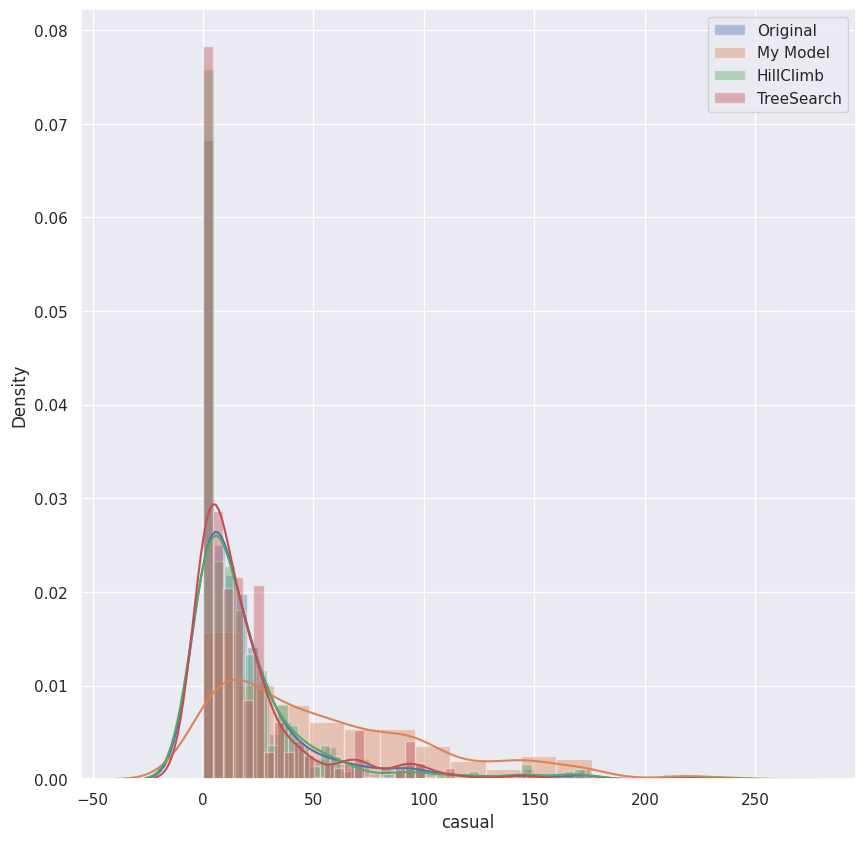

In [21]:
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(bikes['casual'], label='Original')
sns.distplot(mymodel_samples['casual'], label='My Model')
sns.distplot(hc_samples['casual'], label='HillClimb')
sns.distplot(ts_samples['casual'], label='TreeSearch')
plt.legend()
plt.show()

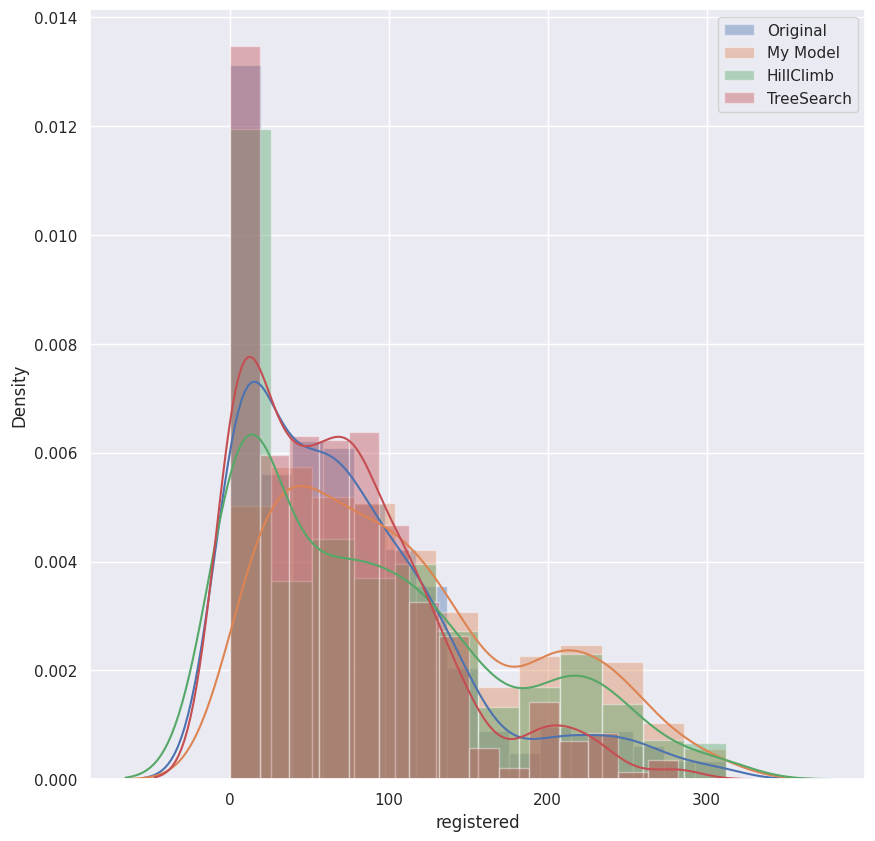

In [22]:
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(bikes['registered'], label='Original')
sns.distplot(mymodel_samples['registered'], label='My Model')
sns.distplot(hc_samples['registered'], label='HillClimb')
sns.distplot(ts_samples['registered'], label='TreeSearch')
plt.legend()
plt.show()

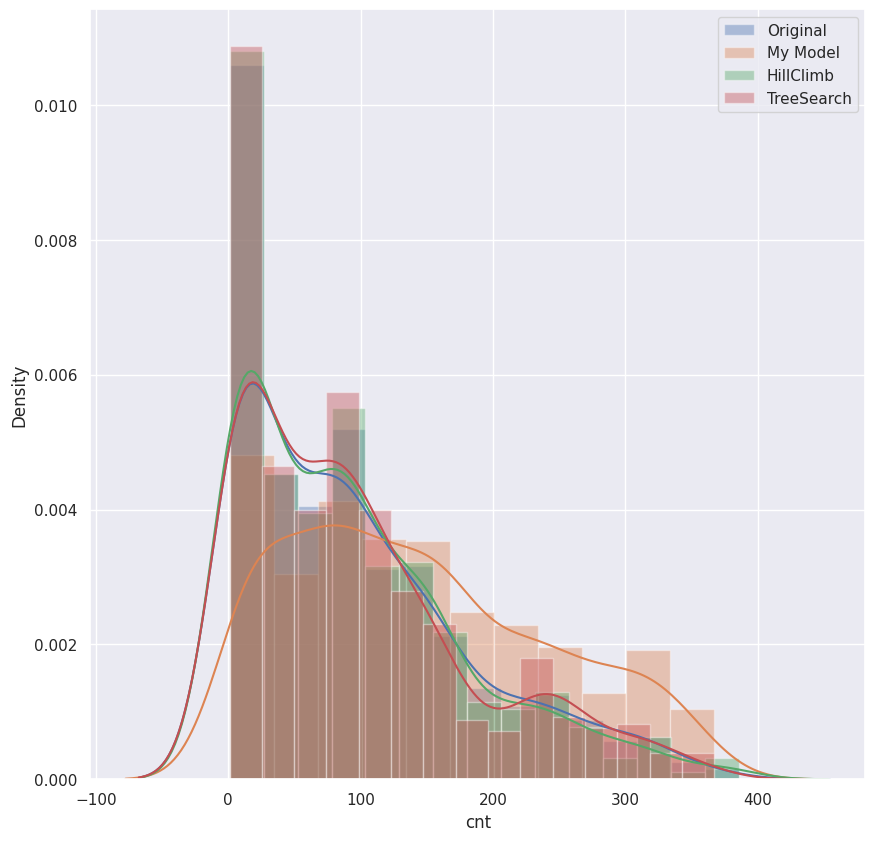

In [23]:
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(bikes['cnt'], label='Original')
sns.distplot(mymodel_samples['cnt'], label='My Model')
sns.distplot(hc_samples['cnt'], label='HillClimb')
sns.distplot(ts_samples['cnt'], label='TreeSearch')
plt.legend()
plt.show()

In [24]:
print("Casual. Model: My Model")
print(f"Mean absolute error:{mean_absolute_error(bikes['casual'], mymodel_samples['casual'])}")
print(f"Mean square error:{mean_squared_error(bikes['casual'], mymodel_samples['casual'])}")
print("Casual. Model: HillClimb")
print(f"Mean absolute error:{mean_absolute_error(bikes['casual'], hc_samples['casual'])}")
print(f"Mean square error:{mean_squared_error(bikes['casual'], hc_samples['casual'])}")
print("Casual. Model: TreeSearch")
print(f"Mean absolute error:{mean_absolute_error(bikes['casual'], ts_samples['casual'])}")
print(f"Mean square error:{mean_squared_error(bikes['casual'], ts_samples['casual'])}")

Casual. Model: My Model
Mean absolute error:50.528
Mean square error:4765.6213333333335
Casual. Model: HillClimb
Mean absolute error:26.481333333333332
Mean square error:1934.7213333333334
Casual. Model: TreeSearch
Mean absolute error:26.148
Mean square error:1830.0546666666667


In [25]:
print("Registered. Model: My Model")
print(f"Mean absolute error:{mean_absolute_error(bikes['registered'], mymodel_samples['registered'])}")
print(f"Mean square error:{mean_squared_error(bikes['registered'], mymodel_samples['registered'])}")
print("Registered. Model: HillClimb")
print(f"Mean absolute error:{mean_absolute_error(bikes['registered'], hc_samples['registered'])}")
print(f"Mean square error:{mean_squared_error(bikes['registered'], hc_samples['registered'])}")
print("Registered. Model: TreeSearch")
print(f"Mean absolute error:{mean_absolute_error(bikes['registered'], ts_samples['registered'])}")
print(f"Mean square error:{mean_squared_error(bikes['registered'], ts_samples['registered'])}")

Registered. Model: My Model
Mean absolute error:87.15066666666667
Mean square error:12144.249333333333
Registered. Model: HillClimb
Mean absolute error:82.01866666666666
Mean square error:11461.602666666668
Registered. Model: TreeSearch
Mean absolute error:68.21066666666667
Mean square error:8249.485333333334


In [26]:
print("Cnt. Model: My Model")
print(f"Mean absolute error:{mean_absolute_error(bikes['cnt'], mymodel_samples['cnt'])}")
print(f"Mean square error:{mean_squared_error(bikes['cnt'], mymodel_samples['cnt'])}")
print("Cnt. Model: HillClimb")
print(f"Mean absolute error:{mean_absolute_error(bikes['cnt'], hc_samples['cnt'])}")
print(f"Mean square error:{mean_squared_error(bikes['cnt'], hc_samples['cnt'])}")
print("Cnt. Model: TreeSearch")
print(f"Mean absolute error:{mean_absolute_error(bikes['cnt'], ts_samples['cnt'])}")
print(f"Mean square error:{mean_squared_error(bikes['cnt'], ts_samples['cnt'])}")

Cnt. Model: My Model
Mean absolute error:109.65733333333333
Mean square error:19194.630666666668
Cnt. Model: HillClimb
Mean absolute error:92.584
Mean square error:14462.28
Cnt. Model: TreeSearch
Mean absolute error:93.644
Mean square error:15207.110666666667
